# Телеком. Прогнозирование оттока клиентов

## Введение

Оператор связи «ТелеДом» борется с оттоком клиентов. Для этого его сотрудники будут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. 

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

**Цель проекта:** на предоставленных данных обучить модель прогнозировать отток клиентов со значением метрики ROC-AUC на тестовой выборке не менее 0.85.
 

**Описание данных:**

***Название таблиц***

 - *telecom.contract — информация о договорах.*

 - *telecom.personal — персональные данные клиентов.*

 - *telecom.internet — информация об интернет-услугах.*

 - *telecom.phone — информация об услугах телефонии.*


***Целевая переменная:*** *EndDate (дата окончания действия договора) в таблице telecom.contract.*


***Содержание таблиц***

  *telecom.contract:*
   - customerID — ID абонента
   - BeginDate — дата начала действия договора;
   - EndDate — дата окончания действия договора;
   - Type — тип оплаты: раз в год-два или ежемесячно; 
   - PaperlessBilling — электронный расчётный лист;
   - PaymentMethod — тип платежа;
   - MonthlyCharges — расходы за месяц;
   - TotalCharges — общие расходы абонента.
  
  
  *telecom.personal:*
   - customerID — ID пользователя;
   - gender — пол;
   - SeniorCitizen — является ли абонент пенсионером;
   - Partner — есть ли у абонента супруг или супруга;
   - Dependents — есть ли у абонента дети.


  *telecom.internet:*
   - customerID — ID пользователя;
   - InternetService — тип подключения;
   - OnlineSecurity — блокировка опасных сайтов;
   - OnlineBackup — облачное хранилище файлов для резервного копирования данных;
   - DeviceProtection — антивирус;
   - TechSupport — выделенная линия технической поддержки;
   - StreamingTV — стриминговое телевидение;
   - StreamingMovies — каталог фильмов.


  *telecom.phone:*
   - customerID — ID пользователя;
   - MultipleLines — подключение телефона к нескольким линиям одновременно.
  

*Информация о договорах актуальна на 1 февраля 2020.*


**План выполнения проекта:**

- Подключиться к базе и загрузить таблицы sql.

- Провести исследовательский анализ данных и их предобработку.

- Подготовить данные и отобрать признаки для обучения.

- Создать и обучить модели для прогноза оттока клиентов.

- Проверить и отобрать лучшую модель.

- Протестировать модель и продемонстрировать её работу.

- Написать промежуточные и общий выводы.

## Подключение к базе. Загрузка таблиц sql

- Загрузим и обновим библиотеки. 

In [1]:
#!pip install phik==0.10.0 -q

In [2]:
#!pip install --upgrade scikit-learn -q

In [3]:
# загружаем библиотеки
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sqlalchemy import create_engine

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import catboost 
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.pipeline import make_pipeline

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve 

# настраиваем отображение
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)
pd.options.mode.chained_assignment = None

# задаем константы 
RANDOM_STATE = 150724

In [4]:
# задаем диапазон категориальных признаков
categorial_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 
                      'Gender', 'SeniorCitizen', 'Partner', 
                      'Dependents','InternetService', 'OnlineSecurity',
                      'OnlineBackup', 'DeviceProtection','TechSupport',
                      'StreamingTV', 'StreamingMovies', 'MultipleLines']
# задаем диапазон количественных признаков
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'DurationContract']

In [5]:
# задаем функции

# задаем функцию для вывода общей информации о датасете
def frame_info(data, name):
    print(f'Таблица:{name}')
    display(data.head(10))
    print()
    data.info()
    print()
    # дубликаты
    print('Абсолютное количество дубликатов:', data.duplicated().sum())
    print()
    print('Относительное количество дубликатов, % :', round(data.duplicated().mean()*100,2))
    print()
    print('Абсолютное количество пропусков:')
    print(data.isna().sum().sort_values())
    print()
    print('Относительное количество пропусков, % :')
    print(round(data.isna().mean()*100,2).sort_values())    
    
# задаем функцию для вывода уникальных значений столбцов 
def values_unique(data, name):
    print(f'Таблица:{name}')
    columns = data.columns
    for column in columns:
        values1 = data[column].unique()
        values2 = data[column].nunique()
        values3 = data[column].value_counts(normalize=True)
        print('Уникальные значения столбца:', column)
        print(values1)
        print('Количество уникальных значений столбца:', column)
        print(values2)
        print('Относительное распределение уникальных значений столбца:', column)
        print(values3)
        print()    

In [6]:
# подключаемся к базе данных:
# задаем конфигурацию базы данных
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
} 

# формируем строку подключения
connection_string = "postgresql://{}:{}@{}:{}/{}".format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

# создаем соединение с базой данных
connection = create_engine(connection_string)
#connection_row = connection.raw_connection()

### Вывод по первому шагу

 - Успешно загрузили библиотеки и подключились к базе.

##  Проведение исследовательского анализа и предобработки данных

### Первичный анализ данных

In [7]:
# создаем функцию обработки и загрузки таблиц
def get_query(query):
    query_df = pd.read_sql_query(con=connection, sql=query)
    return query_df

In [8]:
# выгружаем таблицу contract 
df_contract = '''
SELECT *
FROM telecom.contract
'''
df_contract = get_query(df_contract)
display(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


In [9]:
# выгружаем таблицу personal 
df_personal = '''
SELECT *
FROM telecom.personal
'''
df_personal = get_query(df_personal)
display(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [10]:
# выгружаем таблицу internet 
df_internet = '''
SELECT *
FROM telecom.internet
'''
df_internet = get_query(df_internet)
display(df_internet)

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
...,...,...,...,...,...,...,...,...
5513,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5514,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5515,4801-JZAZL,DSL,Yes,No,No,No,No,No
5516,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [11]:
# выгружаем таблицу phone
df_phone = '''
SELECT *
FROM telecom.phone
'''
df_phone = get_query(df_phone)
display(df_phone)

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
...,...,...
6357,2569-WGERO,No
6358,6840-RESVB,Yes
6359,2234-XADUH,Yes
6360,8361-LTMKD,Yes


- Выгрузим количество строк и столбцов в таблицах, и посмотрим на типы данных.

In [12]:
# создаем запрос для выгрузки количества строк и типов данных
query_columns = '''
WITH 
columns AS (
  SELECT table_name,
         data_type,
         column_name
  FROM information_schema.columns
),

rows AS(     
   SELECT relname,
          reltuples AS rows_count
   FROM pg_class
   WHERE relname IN ('contract', 
                      'personal',
                      'internet', 
                      'phone')
)

SELECT table_name,
       column_name,
       data_type,
       rows_count
FROM columns AS c
JOIN rows AS r ON table_name=relname
WHERE table_name = 
'''
# выгружаем данные
for col in ("'contract'", "'personal'", "'internet'", "'phone'"):
    print()
    print(f'Таблица:{col}')
    query_res = query_columns + str(col)
    display(get_query(query_res))


Таблица:'contract'


,table_name,column_name,data_type,rows_count
0,contract,EndDate,date,7043.0
1,contract,BeginDate,date,7043.0
2,contract,MonthlyCharges,numeric,7043.0
3,contract,TotalCharges,numeric,7043.0
4,contract,PaperlessBilling,text,7043.0
5,contract,Type,text,7043.0
6,contract,customerID,text,7043.0
7,contract,PaymentMethod,text,7043.0



Таблица:'personal'


,table_name,column_name,data_type,rows_count
0,personal,SeniorCitizen,integer,7043.0
1,personal,customerID,text,7043.0
2,personal,gender,text,7043.0
3,personal,Partner,text,7043.0
4,personal,Dependents,text,7043.0



Таблица:'internet'


,table_name,column_name,data_type,rows_count
0,internet,c1,text,5518.0
1,internet,c2,text,5518.0
2,internet,c3,text,5518.0
3,internet,c4,text,5518.0
4,internet,c5,text,5518.0
5,internet,c6,text,5518.0
6,internet,c7,text,5518.0
7,internet,c8,text,5518.0



Таблица:'phone'


,table_name,column_name,data_type,rows_count
0,phone,c1,text,6362.0
1,phone,c2,text,6362.0


In [13]:
# закрываем соединение с базой данных для экономии ресурсов 
connection.dispose()

**Вывод:** 
    
 - Выгрузили таблицы и изучили первичные данные:
   - Количество таблиц соответствует условию задачи.
   - Все таблицы обладают необходимым набором данных. 
   - Во всех таблицах имеется общий ключ для связывания – ***customerID***.
   - Таблицы разного размера. 
   - В таблицах internet и phone названия колонок не на своих местах. 
   - Типы данных соответствуют типу переменной. 

- Исследуем каждую таблицу в отдельности.

### Таблица 'contract'

- В таблице содержатся данные о договорах пользователей. 


- Исследуем данные. 

In [14]:
# выводим информацию о таблице
frame_info(df_contract, "'contract'") 

Таблица:'contract'


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB

Абсолютное количество дубликатов: 0

Относительное количество дубликатов, % : 0.0

Абсолютное количество пропусков:
customerID             0
BeginDate              0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
EndDate             5174
dtype: int64

Относительное количество пропусков, % 

In [15]:
# выводим информацию об уникальных значениях в таблице
values_unique(df_contract, "'contract'")

Таблица:'contract'
Уникальные значения столбца: customerID
['4472-LVYGI' '3115-CZMZD' '3668-QPYBK' ... '2234-XADUH' '4801-JZAZL'
 '3186-AJIEK']
Количество уникальных значений столбца: customerID
7043
Относительное распределение уникальных значений столбца: customerID
8017-LXHFA    0.000142
2267-WTPYD    0.000142
6463-HHXJR    0.000142
9158-VCTQB    0.000142
6202-JVYEU    0.000142
                ...   
6527-PZFPV    0.000142
0988-AADSA    0.000142
3669-OYSJI    0.000142
2144-BFDSO    0.000142
9919-YLNNG    0.000142
Name: customerID, Length: 7043, dtype: float64

Уникальные значения столбца: BeginDate
[datetime.date(2020, 2, 1) datetime.date(2018, 8, 9)
 datetime.date(2019, 1, 26) datetime.date(2018, 12, 26)
 datetime.date(2019, 4, 27) datetime.date(2018, 11, 13)
 datetime.date(2018, 7, 24) datetime.date(2019, 2, 7)
 datetime.date(2019, 5, 3) datetime.date(2019, 1, 16)
 datetime.date(2019, 7, 28) datetime.date(2019, 5, 17)
 datetime.date(2018, 11, 8) datetime.date(2018, 12, 24)
 datetim

**Предварительный вывод:**
- Датафрейм содержит 7043 строки и 8 колонок.
- На первый взгляд, данные распределены нормально и равномерно.
- В столбце customerID содержатся идентификаторы клиентов.
- В датафрейме три категориальных нечисловых признака: Type, PaperlessBilling и PaymentMethod.  
- Дубликатов в датафрейме нет.
- В столбцах BeginDate и EndDate значения не соответствуют типу.
- Количество значений в столбцах с датами кардинально разное: договор можно заключить в любой момент, а расторгается он, видимо, по итогам месячного платежного периода. 
- В солбце EndDate 5174 пропуска, что составляет чуть более 73% от общего количества значений. Пропуски, скорее всего означают, что контракт еще действует. 
- В столбце TotalCharges всего 11 пропусков, которые, видимо, говорят о том, что клиент не пользуется платными услугами или не успел их оплатить.    


**План на предобработку:**

- Поменяем тип данных в столбцах с датами.
- Заменим пропуски в столбце EndDate на значение 'No' – контракт не окончен. 
- Заменим пропуски в столбце TotalCharges на значение столбца MonthlyCharges.
- Изменим название столбца customerID (приведем в соответствие с названиями других колонок). 

In [16]:
# меняем значения в столбце BeginDate на тип даты
df_contract['BeginDate'] = pd.to_datetime(
    df_contract['BeginDate'], 
    format='%Y-%m-%d')

# проверяем
df_contract['BeginDate'].head()

0   2020-02-01
1   2020-02-01
2   2018-08-09
3   2020-02-01
4   2019-01-26
Name: BeginDate, dtype: datetime64[ns]

In [17]:
# меняем значения в столбце EndDate на тип даты
df_contract['EndDate'] = pd.to_datetime(
    df_contract['EndDate'], 
    format='%Y-%m-%d')

In [18]:
# меняем пропуски в столбце EndDate
df_contract.loc[df_contract['EndDate'].isna(), 'EndDate'] = 'No'

# проверяем
display(df_contract['EndDate'].isna().sum())
df_contract['EndDate'].head()

0

0                     No
1                     No
2    2019-12-01 00:00:00
3                     No
4    2019-11-01 00:00:00
Name: EndDate, dtype: object

- Перед заменой пропусков в TotalCharges проверим информацию о клиентах с отсутствующей суммой оплаты.  

In [19]:
# выводим клиентов с пропусками  
df_contract[df_contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN


In [20]:
# выводим клиентов, недавно заключивших договор 
df_contract.sort_values(by='BeginDate', 
                        ascending=False).head(12)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
9,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
6839,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN
5160,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
1,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
11,2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,NaN
10,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
4408,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
6,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
3,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN


- Гипотеза об оплате подтвердилась. Заменим пропуски на значение столбца расходов за месяц (MonthlyCharges).  

In [21]:
# меняем пропуски в столбце TotalCharges
df_contract['TotalCharges'].fillna(df_contract[
         df_contract['TotalCharges'].isna()]['MonthlyCharges'
                                              ],inplace = True)

# проверяем 
df_contract['TotalCharges'].isna().sum()

0

In [22]:
# меняем название столбца customerID
df_contract.rename(columns={"customerID": "CustomerID"}, inplace=True)

In [23]:
# выводим итоговый результат
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


**Вывод:**

- Изучили данные в таблице contract и провели первичную предобработку.

### Таблица 'personal'

- В таблице содержатся данные о пользователях. 


- Исследуем данные. 

In [24]:
# выводим информацию о таблице
frame_info(df_personal, "'personal'") 

Таблица:'personal'


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Абсолютное количество дубликатов: 0

Относительное количество дубликатов, % : 0.0

Абсолютное количество пропусков:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Относительное количество пропусков, % :
customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64


In [25]:
# выводим информацию об уникальных значениях в таблице
values_unique(df_personal, "'personal'")

Таблица:'personal'
Уникальные значения столбца: customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Количество уникальных значений столбца: customerID
7043
Относительное распределение уникальных значений столбца: customerID
8017-LXHFA    0.000142
1794-SWWKL    0.000142
0178-SZBHO    0.000142
5167-GBFRE    0.000142
2267-WTPYD    0.000142
                ...   
4700-UBQMV    0.000142
9050-QLROH    0.000142
4566-NECEV    0.000142
7176-WRTNX    0.000142
1354-YZFNB    0.000142
Name: customerID, Length: 7043, dtype: float64

Уникальные значения столбца: gender
['Female' 'Male']
Количество уникальных значений столбца: gender
2
Относительное распределение уникальных значений столбца: gender
Male      0.504756
Female    0.495244
Name: gender, dtype: float64

Уникальные значения столбца: SeniorCitizen
[0 1]
Количество уникальных значений столбца: SeniorCitizen
2
Относительное распределение уникальных значений столбца: SeniorCitizen
0    0.837853
1    0

**Предварительный вывод:**
- Датафрейм содержит 7043 строки и 5 колонок.
- На первый взгляд, данные распределены нормально и равномерно во всех столбцах, кроме SeniorCitizen и Dependents, где наблюдается явный дисбаланс классов. 
- В столбце customerID содержатся идентификаторы клиентов.
- В датафрейме три категориальных нечисловых признака: gender, Partner и Dependents и один категориальный числовой: SeniorCitizen .  
- Дубликатов и пропусков в датафрейме нет.
- Все данные соответствуют своему типу.


**План на предобработку:**

- Изменим названия столбцов customerID и gender (приведем в соответствие с названиями других колонок).

In [26]:
# меняем название столбца customerID и gender
df_personal.rename(columns={"customerID": "CustomerID", "gender": "Gender"}, inplace=True)

# проверяем
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Вывод:**

- Изучили данные в таблице personal и провели первичную предобработку.


### Таблица 'internet'

- В таблице содержатся данные об интернет-услугах. 


- Перед исследованием даных, отредактируем названия колонок.

In [27]:
# меняем названия колонок 
df_internet.columns = df_internet.iloc[0]
# сбрасываем индекс
df_internet = df_internet[1:].reset_index(drop=True)

- Исследуем данные. 

In [28]:
# выводим информацию о таблице
frame_info(df_internet, "'internet'") 

Таблица:'internet'


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Абсолютное количество дубликатов: 0

Относительное количество дубликатов, % : 0.0

Абсолютное количество пропусков:
0
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Относительное количество пропусков, % :
0
customerID          0.0
InternetService 

In [29]:
# выводим информацию об уникальных значениях в таблице
values_unique(df_internet, "'internet'")

Таблица:'internet'
Уникальные значения столбца: customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Количество уникальных значений столбца: customerID
5517
Относительное распределение уникальных значений столбца: customerID
8017-LXHFA    0.000181
3512-IZIKN    0.000181
2856-NNASM    0.000181
9494-BDNNC    0.000181
4723-BEGSG    0.000181
                ...   
1162-ECVII    0.000181
1136-XGEQU    0.000181
0516-WJVXC    0.000181
6576-FBXOJ    0.000181
0218-QNVAS    0.000181
Name: customerID, Length: 5517, dtype: float64

Уникальные значения столбца: InternetService
['DSL' 'Fiber optic']
Количество уникальных значений столбца: InternetService
2
Относительное распределение уникальных значений столбца: InternetService
Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

Уникальные значения столбца: OnlineSecurity
['No' 'Yes']
Количество уникальных значений столбца: OnlineSecurity
2
Относительное распределение уник

**Предварительный вывод:**
- Датафрейм содержит 5517 строк и 8 колонок.
- На первый взгляд, данные распределены нормально и равномерно во всех столбцах, кроме TechSupport и OnlineSecurity, где наблюдается явный дисбаланс классов. 
- В столбце customerID содержатся идентификаторы клиентов.
- Датафрейм состоит из семи категориальных нечисловых признака.  
- Дубликатов и пропусков нет.
- Все данные соответствуют своему типу.


**План на предобработку:**

- Изменим название столбца customerID (приведем в соответствие с названиями других колонок).

In [30]:
# меняем название столбца customerID и gender
df_internet.rename(columns={"customerID": "CustomerID"}, inplace=True)

# проверяем
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Вывод:**

- Изучили данные в таблице internet и провели первичную предобработку.

- Почти половина всех абонентов не пользуется интернет-услугами. Возможно, такие абоненты не имеют смартфонов. 

### Таблица 'phone'

- В таблице содержатся данные об информация об услугах телефонии. 


- Перед исследованием даных, отредактируем названия колонок.

In [31]:
# меняем названия колонок 
df_phone.columns = df_phone.iloc[0]
# сбрасываем индекс
df_phone = df_phone[1:].reset_index(drop=True)

In [32]:
# выводим информацию о таблице
frame_info(df_phone, "'phone'") 

Таблица:'phone'


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Абсолютное количество дубликатов: 0

Относительное количество дубликатов, % : 0.0

Абсолютное количество пропусков:
0
customerID       0
MultipleLines    0
dtype: int64

Относительное количество пропусков, % :
0
customerID       0.0
MultipleLines    0.0
dtype: float64


In [33]:
# выводим информацию об уникальных значениях в таблице
values_unique(df_phone, "'phone'")

Таблица:'phone'
Уникальные значения столбца: customerID
['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
Количество уникальных значений столбца: customerID
6361
Относительное распределение уникальных значений столбца: customerID
8017-LXHFA    0.000157
2294-DMMUS    0.000157
9158-VCTQB    0.000157
6202-JVYEU    0.000157
8547-NSBBO    0.000157
                ...   
6101-IMRMM    0.000157
6797-LNAQX    0.000157
0623-GDISB    0.000157
4700-UBQMV    0.000157
1354-YZFNB    0.000157
Name: customerID, Length: 6361, dtype: float64

Уникальные значения столбца: MultipleLines
['No' 'Yes']
Количество уникальных значений столбца: MultipleLines
2
Относительное распределение уникальных значений столбца: MultipleLines
No     0.532935
Yes    0.467065
Name: MultipleLines, dtype: float64



**Предварительный вывод:**
- Датафрейм содержит 6361 строку и 2 колонки.
- На первый взгляд, данные распределены нормально и равномерно. 
- В столбце customerID содержатся идентификаторы клиентов.
- В датафрейме один категориальный нечисловой признак: MultipleLines.  
- Дубликатов и пропусков в датафрейме нет.
- Все данные соответствуют своему типу.


**План на предобработку:**

- Изменим название столбца customerID (приведем в соответствие с названием другой колонки).

In [34]:
# меняем название столбца customerID и gender
df_phone.rename(columns={"customerID": "CustomerID"}, inplace=True)

# проверяем
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Вывод:**

- Изучили данные в таблице phone и провели первичную предобработку.

- Чуть меньше половины абонентов не пользуются стационарной телефонной связью, видимо, предпочитая обычный мобильный телефон или смартфон.

- Перейдем к объединению таблиц.

### Объединение таблиц

- В объединенный датафрейм должны войти все пользователи, с которыми заключен контракт и о которых в базе содержится персональная информация. Значит, основа объединения – это таблицы contract и personal. Так как количество уникальных CustomerID у них совпадает, таблицы  можно объединить с атрибутом  inner.


- Таблицы с услугами содержат меньше уникальных CustomerID, часть из которых может пересекаться, поэтому эти таблицы будем присоединять к основным с атрибутом left.


- Получившиеся в результате объединения пропуски – это свидетельство того, что абоненты еще не подключили услугу. Поэтому такие пропуски можно будет заменить на 'No_internet' и 'No_hpone' (отсутствие подключения к услуге).


- Заменим тип данных в столбце 'SeniorCitizen' на object.

In [35]:
df_main = df_contract.merge(df_personal, on='CustomerID')
df_main = df_main.merge(df_internet, how='left', on='CustomerID')
df_main = df_main.merge(df_phone, how='left', on='CustomerID')

In [36]:
# проверяем результат объединения
print('Количество уникальных пользователей:', df_main.CustomerID.nunique())
print()
print('Размер датафрейма:', df_main.shape)

Количество уникальных пользователей: 7043

Размер датафрейма: (7043, 20)


- Количество пользователей совпадает с количеством объектов. Значит столбец СustomerID можно удалить. Сделаем его индексом. 

In [37]:
# формируем индекс таблицы из столбца CustomerID
df_main = df_main.set_index('CustomerID')

# проверяем
print('Размер датафрейма:', df_main.shape)
print()
df_main.info()

Размер датафрейма: (7043, 19)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 4472-LVYGI to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   obj

- Обработаем пропуски в столбцах. 

In [38]:
# заполняем пропуски в столбцах с услугами телефонии
df_main['MultipleLines'].fillna('no_phone', inplace = True)

In [39]:
# заполняем пропуски в столбцах с интернет-услугами 
df_main.fillna('no_internet', inplace = True)

# проверяем
print(sum(df_main.isna().sum()))

0


- Приведем категориальные значения в столбце SeniorCitizen к строковому  типу. 

In [40]:
# меняем значения в столбце 
df_main['SeniorCitizen'] = df_main['SeniorCitizen'].astype('object')

In [41]:
# выводим итоговый датафрейм    
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 4472-LVYGI to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

**Вывод:**
    
- Успешно объединили четыре таблицы, обработали столбец с ID и заполнили пропуски. 

- Размер объединенного датафрейма: (7043, 19). 

### Генерация новых признаков

- Сгенерируем новый признак, который может пригодиться при обучении и выделим в целевую переменную признак EndDate.

-  Выделим в целевую переменную признак EndDate: создадим новый столбец с двумя значениями: 0 и 1. Дата 2020-02-01 в столбце 'EndDate' будет соответствовать значению 0 – контракт еще действует. Любая более ранняя дата в этом столбце будет тождестенна значению 1 – контракт расторгнут.  

In [42]:
# создаем функцию замены значений
def change_values(end_date):
    if end_date == 'No':
        return 0
    else:
        return 1

# создаем столбец с новым признаком 
df_main['Exited'] = df_main['EndDate'].apply(change_values)

# проверяем  
display(df_main.Exited.value_counts(normalize=True)) # доли
display(df_main.Exited.value_counts()) # абсолютные значения
display(df_main.Exited.describe())
df_main.info()

0    0.73463
1    0.26537
Name: Exited, dtype: float64

0    5174
1    1869
Name: Exited, dtype: int64

count    7043.000000
mean        0.265370
std         0.441561
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Exited, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 4472-LVYGI to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

- Заменим значение 'No' на дату актуальности (01/02/2020) и приведем к соответствующему типу.  

In [43]:
# меняем заглушку в столбце EndDate на дату актуальности
df_main.loc[df_main['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

# приводим значения к типу даты
df_main['EndDate'] = pd.to_datetime(
    df_main['EndDate'], 
    format='%Y-%m-%d')

# проверяем
df_main.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Exited
CustomerID,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,no_phone,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,Male,0,No,Yes,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0
3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


- Создадим признак продолжительности контракта абонента в днях (разница между датой начала действия контракта и датой его окончания): это важный критерий характеристики пользователя. Возможно (проверим это в исследовании), чем дольше абонент пользуется услугами, тем более неохотно от них отказывается. И наоборот. 

In [44]:
# создаем столбец с новым признаком 
df_main['DurationContract']=(df_main['EndDate']-df_main['BeginDate'])/np.timedelta64(1,'D')    

In [45]:
# проверяем  
display(df_main.DurationContract.value_counts(normalize=True))
display(df_main.DurationContract.describe())
df_main.info()

304.0    0.006531
299.0    0.006247
283.0    0.006247
274.0    0.005963
308.0    0.005963
           ...   
77.0     0.000142
52.0     0.000142
103.0    0.000142
59.0     0.000142
54.0     0.000142
Name: DurationContract, Length: 476, dtype: float64

count    7043.000000
mean      297.378674
std        83.868181
min         0.000000
25%       242.000000
50%       298.000000
75%       351.000000
max       583.000000
Name: DurationContract, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 4472-LVYGI to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

-  В новом признаке присутствуют нулевые значения. Видимо день окончания контракта совпал с датой актуальности.  Посчитаем эти значения и заменим на 1. 

In [46]:
# считаем нулевые значения 
len(df_main.loc[df_main['DurationContract'] == 0])

11

In [47]:
# меняем нули на 1
df_main.loc[df_main['DurationContract'] == 0., 'DurationContract'] = 1

# проверяем
len(df_main.loc[df_main['DurationContract'] == 0])

0

- Поменяем порядок колонок: поставим на последнее место целевой признак. 

In [48]:
# удаляем столбец 'Exited'
Exited = df_main['Exited']
df_main = df_main.drop('Exited', axis=1)
 
# вставляем столбец Exited на последнее место
df_main.insert(len(df_main.columns), 'Exited', Exited)

# проверяем
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 4472-LVYGI to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

- Удалим из датафрейма признаки с датой – они больше не актуальны в этом проекте. 

In [49]:
# удаляем ненужные столбцы
df_main.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)

# проверяем
print('Размер датафрейма:', df_main.shape)
print()
df_main.info()

Размер датафрейма: (7043, 19)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 4472-LVYGI to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   object 
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  M

- После преобразований проверим наличие дубликатов.

In [50]:
# проверяем наличие дубликатов
df_main.duplicated().sum()

0

In [51]:
# удаляем использованные таблицы
del df_contract
del df_personal
del df_internet
del df_phone
del Exited 

- Удалим ненужные переменные.

**Вывод:**

- Сгенерировали новый признак (DurationContract), выделили целевую переменную Exited на основе признака EndDate и удалили лишние столбцы. 

### Анализ объединенных данных 

- Визуализируем распределение значений и соотношение ушедших и оставшихся клиентов для каждого признака.

- Изучим кореляцию признаков между собой и целевой переменной. 

#### Количественные признаки

- Посмотрим распределение пользователей по значениям количественных признаков.

In [52]:
# создаем функцию построения графиков для количественных признаков
def hist_numeric_col(col, bins, xlim, sizebox):

    # строим гистограмму
    plt.figure(figsize=(10,6))
    sns.histplot(data=df_main,
             x=col, 
             hue='Exited',
             common_norm=False,    
             multiple='stack', 
             bins=bins)
    plt.xlabel(col)
    plt.ylabel('Количество пользователей')
    plt.title(f'Общее распределение пользователей по "{col}"')
    plt.xlim(xlim)

    # строим диаграмму размаха (боксплот)    
    plt.figure(figsize=sizebox)    
    sns.boxplot(data=df_main[col], orient='h')
    plt.title(f'Общее распределение пользователей по "{col}"')
    plt.xlabel(col)    
    plt.tight_layout()

    # строим нормированную гисторамму  
    plt.figure(figsize=(10,6))
    sns.histplot(data=df_main,
             x=col,
             hue='Exited',
             stat='density', 
             common_norm=False,
             bins=bins,
             multiple='fill', element="step")
    plt.title(f'Доля абонентов, расторгнувших контракт по "{col}"')
    plt.ylabel('Плотность распределения пользователей')
    plt.show()

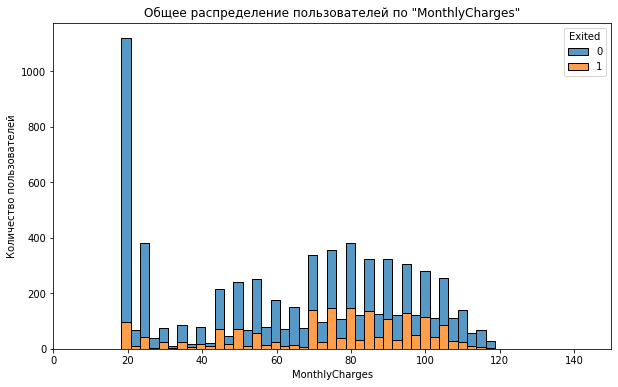

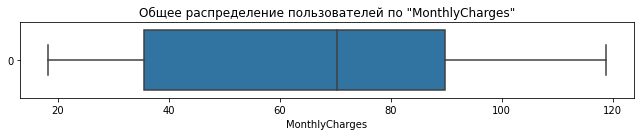

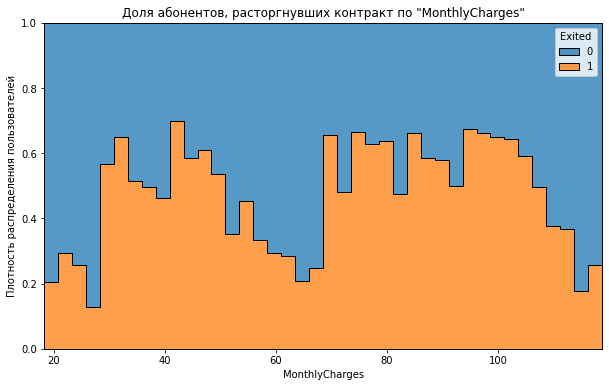

In [53]:
# строим график для 'MonthlyCharges'
hist_numeric_col('MonthlyCharges', 40, (0,150), (9,2))

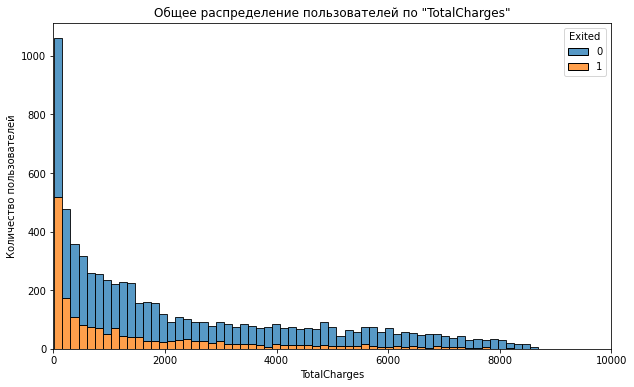

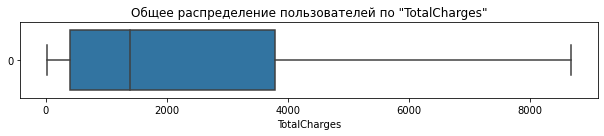

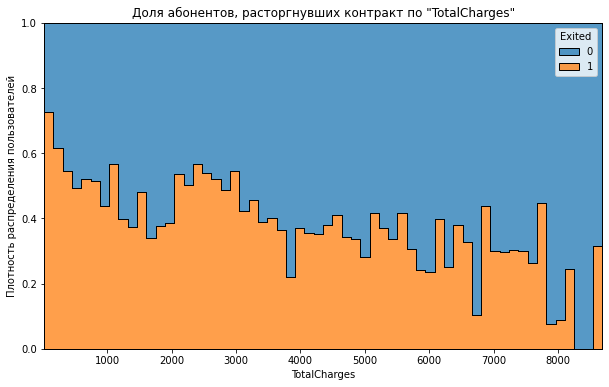

In [54]:
# строим график для 'TotalCharges'
hist_numeric_col('TotalCharges', 60, (0,10000), (8.5,2))

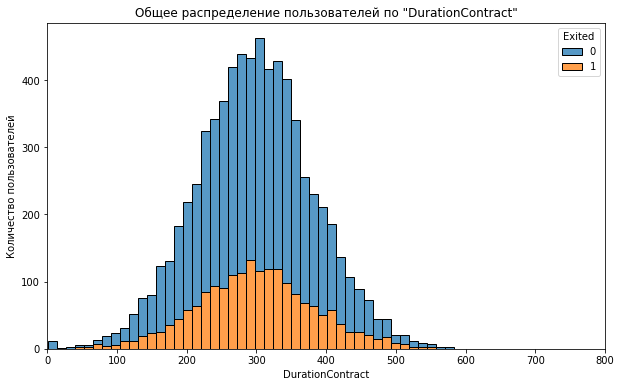

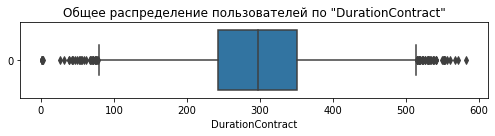

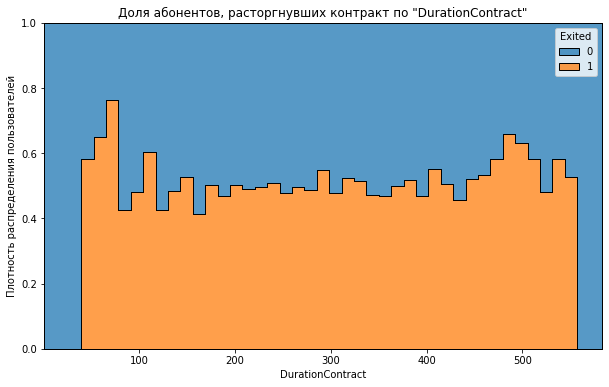

In [55]:
# строим график для 'DurationContract'
hist_numeric_col('DurationContract', 45, (0,800), (7,2))

In [56]:
# смотрим распределение в цифрах
df_main[numeric_columns].describe()

,MonthlyCharges,TotalCharges,DurationContract
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,297.380236
std,30.090047,2266.730170,83.862651
min,18.250000,18.800000,1.000000
25%,35.500000,398.550000,242.000000
50%,70.350000,1394.550000,298.000000
75%,89.850000,3786.600000,351.000000
max,118.750000,8684.800000,583.000000


**Вывод:**

- Значения признака **MonthlyCharges** распределены полимодально с большим пиком в районе 20 и пиками поменьше в районах 50 и 85. Что, видимо, объясняется тарифами на услуги. Большая часть значений сосредоточена в диапазоне 35-90. С ростом суммы ежемесячного платежа количество абонентов снижается также, как количество ушедших пользователей. Характерно, что среди пользователей, с большей суммой ежемесячных затрат доля тех, кто расторг договор, больше. Распределение по долям ушедших/оставшихся в признаке неоднородно. Основная высокая доля ушедших сосредоточена в диапазонах 80-100 и 30-50, а наименьшая – в 20-30 и выше 120.     


- Сумма общих расходов (**TotalCharges**) находится в прямой зависимости от количества абонентов: с ростом суммы, количество действующих контрактов убывает. Очевидно, люди предпочитают платить меньше. Большая часть значений сосредоточена в диапазоне 350-3900. Доля ушедших плавно снижается с увеличением общей суммы трат. 


- Значения признака **DurationContract** (продолжительность контракта в днях) распределены нормально. Среднее значение самое частое. В среднем контракт длится 300 дней.  Гипотеза о том, что неохотнее разрывают контракт те, кто дольше пользуется услугами, не подтвердилась. Напротив, доля абонентов, расторгнувших контракт выше и среди новичков, и среди старожилов. Меньше всего доля уходящих пользователей среди тех, кто пользуется услугами 250-350 дней.  Доли ушедших и оставшихся почти равномерны практически на всем диапазоне значений, кроме крайних точек (до 50 и свыше 550), где ушедших пользователей не наблюдается.  

#### Категориальные признаки

- Посмотрим распределение значений категориальных признаков.

In [57]:
# создаем функцию построения графиков распределения значений категориальных признаков
def plotly_col(data, ylim, xlabel):
    (data.groupby('Exited')[xlabel]
     .value_counts()
     .unstack(0)
     .apply(lambda x: x/data.shape[0]) # нормализуем данные
     .plot(
        kind='bar',
        xlim=(0,1), 
        ylim=(ylim), 
        grid=True,
        legend=True,
        figsize=(8, 4),
        alpha=.8)
    )
   
    plt.xlabel(f'Значения признака "{xlabel}"')
    plt.ylabel('Относительное количество значений')
    plt.title(f'Распределение значений признака "{xlabel}"')
    plt.show()    

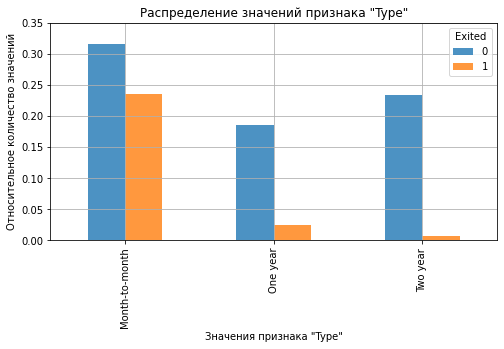

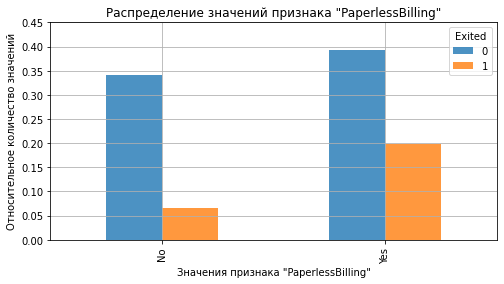

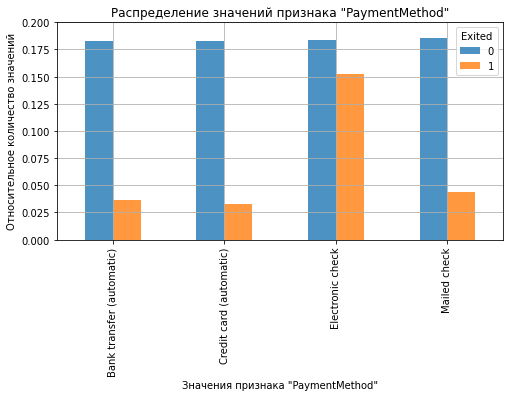

In [58]:
# строим графики признаков 'Type', 'PaperlessBilling' и 'PaymentMethod'. 
plotly_col(df_main, (0,0.35), categorial_columns[0])
plotly_col(df_main, (0,0.45), categorial_columns[1])
plotly_col(df_main, (0,0.2), categorial_columns[2])

**Вывод:**

-  С одной стороны, количество пользователей с ежемесячным типом оплаты (**Type**) больше, с другой – такие пользователи чаще уходят. Среди тех, кто оплачивает услуги раз в два года, доля ушедших мизерна. 


- Тех, кто предпочитает электронный расчётный лист (**PaperlessBilling**), большинство, но и уходят они чаще. 


- Способ оплаты (**PaymentMethod**), напротив, не сильно влияет на общее количество абонентов. А вот доля тех, кто разорвал контракт, больше среди абонентов, предпочитающих электронный чек. Возможно, такой способ оплаты не всем подходит.

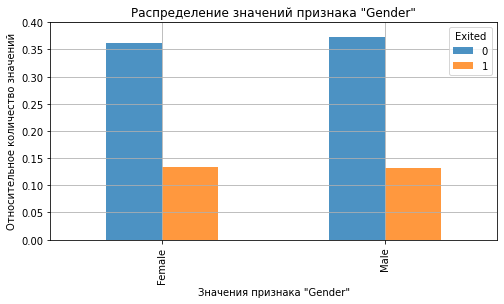

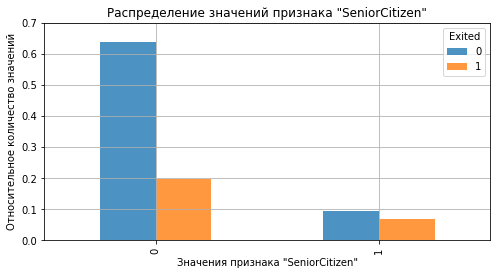

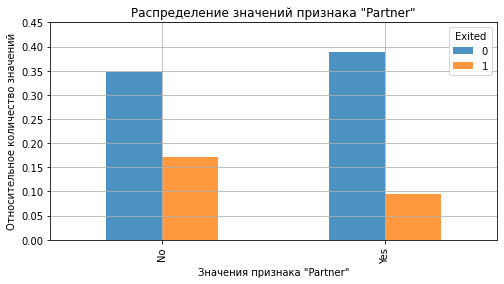

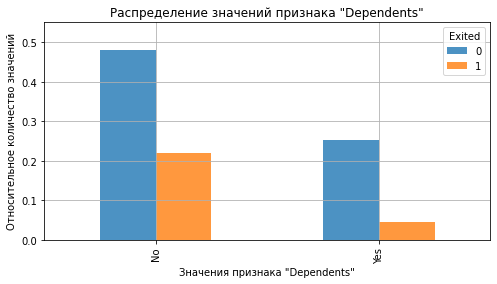

In [59]:
# строим графики признаков 'Gender', 'SeniorCitizen', 'Partner' и 'Dependents'.
plotly_col(df_main, (0,0.4), categorial_columns[3])
plotly_col(df_main, (0,0.7), categorial_columns[4])
plotly_col(df_main, (0,0.45), categorial_columns[5])
plotly_col(df_main, (0,0.55), categorial_columns[6])

**Вывод:**

- По признаку пола (**Gender**) абоненты распределены равномерно. Доля ушедших, похоже, от пола абонента также не зависит.

- Пенсионеров (**SeniorCitizen**) среди пользователей в процентном соотношении совсем немного. И чаще уходят как раз такие абоненты. Но, возможно, это не связано с уровнем качества услуг. 

- Абонентов с партнерами и без (**Partner**) почти поровну, но доля разорвавших контракт больше среди одиноких. 

- Бездетных пользователей большинство (**Dependents**), и они же чаще, в долевом отношении, отказываются от услуг компании. 

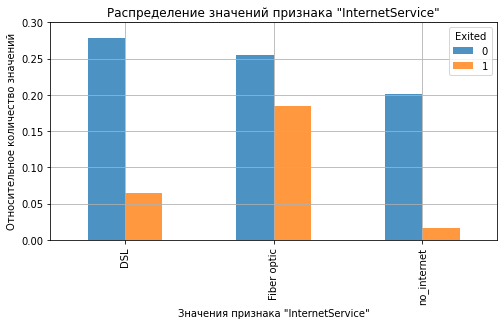

In [60]:
# строим графики признаков 'InternetService'
plotly_col(df_main, (0,0.3), categorial_columns[7])

**Вывод:**

-  Среди тех, кто пользуется традиционным подключением через телефонный кабель (DSL) **InternetService**, отток пользователей меньше. Видимо, продвинутые абоненты более чувствительны к тенденциям рынка и качеству предлагаемых услуг. Еще меньше отток среди не подключившихся к услуге абонентов – видимо, это новички. 

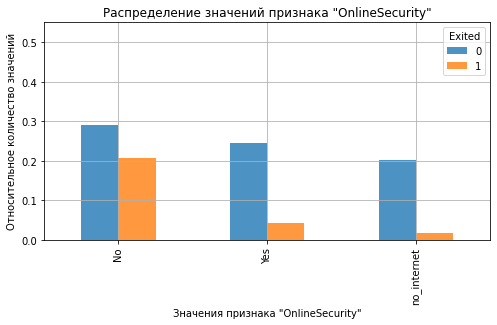

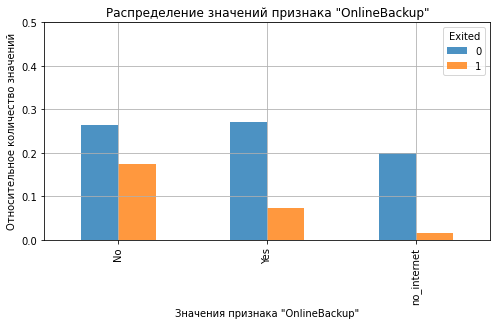

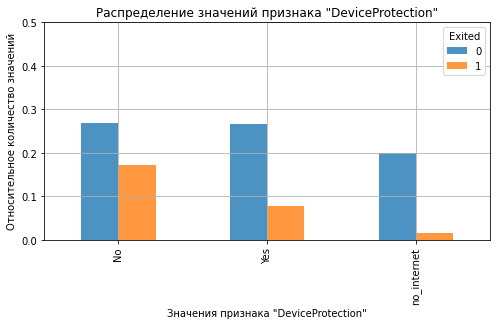

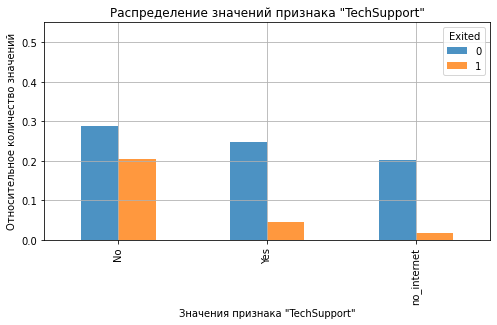

In [61]:
# строим графики признаков, 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection' и 'TechSupport'
plotly_col(df_main, (0,0.55), categorial_columns[8])
plotly_col(df_main, (0,0.5), categorial_columns[9])
plotly_col(df_main, (0,0.5), categorial_columns[10])
plotly_col(df_main, (0,0.55), categorial_columns[11])

**Вывод:**

- Классы и доли ушедших/оставшихся среди пользующихся интернет-услугами **OnlineSecurity**, **OnlineBackup**,  **DeviceProtection**, **TechSupport** имеют схожее распределение, но абоненты, которые этими услугами пользуются, менее склонны к уходу. Особенно, пользующиеся блокировкой опасных сайтов и техподдержкой. Видимо, они более довольны качеством сервиса, чем, те, кто эти услуги не подключил. Среди не подключенных к услугам абонентов отток значительно ниже – скорее всего, речь о новых пользователях. 

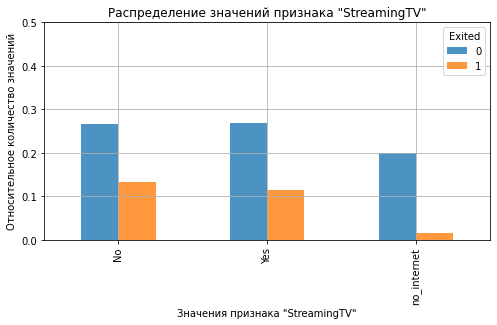

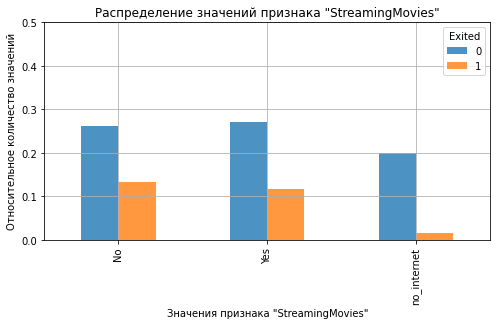

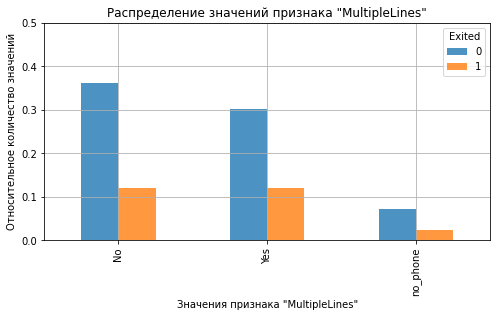

In [62]:
# строим графики признаков, 'StreamingTV', 'StreamingMovies' и 'MultipleLines'.
plotly_col(df_main, (0,0.5), categorial_columns[12])
plotly_col(df_main, (0,0.5), categorial_columns[13])
plotly_col(df_main, (0,0.5), categorial_columns[14])

**Вывод:**

- Абонентов, не пользующихся стриминговым телевидением **StreamingTV**, **StreamingMovies** и мультиканальной телефонной линией **MultipleLines** большинство, но подключение таких услуг почти не влияет на уход пользователей. Пользователи, не неподключенные к услугам почти не утекают – скорее всего, это новички. 

In [63]:
# формируем примерный портрет пользователя, максимально склонного к отказу              
for column in df_main.columns[:-1]:    
    print(column, df_main.groupby(column)['Exited'].sum().idxmax())

Type Month-to-month
PaperlessBilling Yes
PaymentMethod Electronic check
MonthlyCharges 74.4
TotalCharges 20.2
Gender Female
SeniorCitizen 0
Partner No
Dependents No
InternetService Fiber optic
OnlineSecurity No
OnlineBackup No
DeviceProtection No
TechSupport No
StreamingTV No
StreamingMovies No
MultipleLines Yes
DurationContract 292.0


**Вывод:**

- Гипотетический пользователь, максимально склонный к отказу от услуг, в большинстве случаев, оплачивает услуги ежемесячно, предпочитая электронные платежи и электронные чеки. Тратит такой собирательный абонент либо около 75 в месяц, либо около 20 за весь период. Это незамужняя бездетная работающая женщина, которая пользуется оптоволоконным интернет-кабелем, использует мультиканальную телефонию и не пользуется интернет-услугами. Срок контракта такого пользователя составляет около 10 месяцев. 

#### Целевой признак

- Посмотрим распределение классов целевого признака.

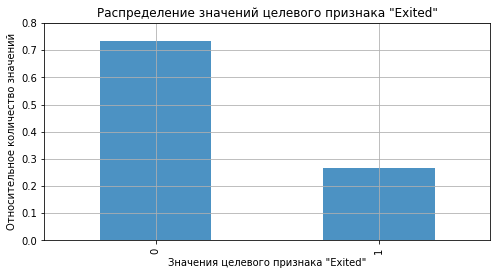

Распределение классов целевого признака, % :


0    0.73463
1    0.26537
Name: Exited, dtype: float64

In [64]:
# строим график распределения значений целевого признака
(df_main['Exited']
     .value_counts(normalize=True)# нормализуем данные
     .plot(
        kind='bar',
        xlim=(0,1), 
        ylim=(0,0.8), 
        grid=True,
        figsize=(8, 4),
     alpha=.8)
    )
   
plt.xlabel('Значения целевого признака "Exited"')
plt.ylabel('Относительное количество значений')
plt.title('Распределение значений целевого признака "Exited"')
plt.show()
print('Распределение классов целевого признака, % :')
display(df_main['Exited'].value_counts(normalize=True))

**Вывод:**

- Классы целевой переменной не сбалансированы. Доля действующих пользователей превышает долю ушедших (1:3). Нужно будет учесть это при обучении. 

#### Корреляция признаков

- Составим корреляционную тепловую карту признаков. 

In [65]:
# выбираем столбцы
columns = df_main.columns

# выбираем интервал
interval_cols = numeric_columns + ['Exited']

# задаем матрицу корреляции
corr_matrix = df_main[columns].phik_matrix(interval_cols=interval_cols)

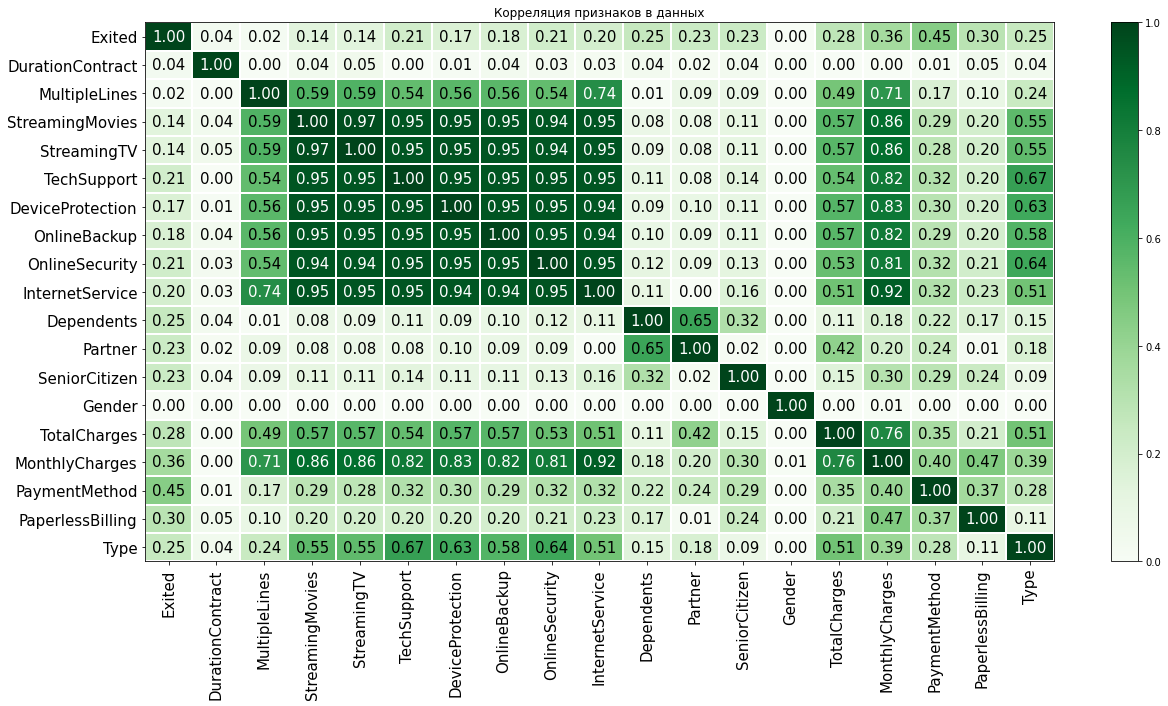

In [66]:
# визуализируем матрицу корреляции через тепловую карту
plot_correlation_matrix(corr_matrix.values, 
                        x_labels = corr_matrix.columns,
                        y_labels = corr_matrix.index,
                        vmin = 0,
                        vmax = 1,
                        color_map= "Greens",
                        fontsize_factor = 1.5,
                        figsize = (18, 10))
plt.title('Корреляция признаков в данных')
plt.show(); 

**Вывод:**

- Наибольшую взаимную корреляцию показывают признаки *InternetService* и *MonthlyCharges*. Очевидно, чем больше сервисов использует абонент, тем выше ежемесячная оплата. При этом у *MonthlyCharges* высокая взаимная корреляция с целевым признаком, в отличие от родственного – *TotalCharges*.


- Также у признака *MonthlyCharges* сильная взаимная зависимость с признаками типов интернет-услуг, что тоже объяснимо: доступ к таким услугам, как правило, предоставляют по ежемесячной подписке. 


- Наибольшая корреляция с целевым признаком у *PaymentMethod*, наименьшая – у *Gender* – признаком пола. 


- Признак *Gender* также выделяется тем, что очень слабо коррелирует со всеми остальными.

- Несмотря на сильную мультиколлинеарность признаков, их удаление приведет к снижению качества работы модели – снижению метрики прогнозирования и вызовет сложности при анализе результатов. Поэтому, мы не будем удалять признаки, а чтобы модели работали стабильно, используем инструменты регуляризации.

- Сформируем список обучающих признаков.

In [67]:
# задаем колонки на исключение
col_del=['Exited']

# формируем список признаков
features_columns = df_main.columns[~df_main.columns.isin(col_del)].tolist()

# проверяем
print('Признаки, выделенные для обучения:')
display(features_columns)
print('Количество выделенных признаков:', len(features_columns))

Признаки, выделенные для обучения:


['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'DurationContract']

Количество выделенных признаков: 18


- Разделим признаки на категориальные и количественные.

In [68]:
# аккумулируем категориальные признаки
features_categories = []
for i in features_columns:
    for c in categorial_columns:
        if i == c: features_categories.append(i)

# аккумулируем количественные признаки
features_numeric = []
for i in features_columns:
    for n in numeric_columns:
        if i == n: features_numeric.append(i)

# проверяем            
print(f'Категориальные признаки, {len(features_categories)} шт. :') 
display(features_categories)
print()
print(f'Числовые признаки {len(features_numeric)} шт. :')
display(features_numeric)

Категориальные признаки, 15 шт. :


['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']


Числовые признаки 3 шт. :


['MonthlyCharges', 'TotalCharges', 'DurationContract']

**Вывод:** 

- Выделили 18 потенциальных признаков для обучения: 3 количественных и 15 категориальных. 

### Подготовка данных для обучения

- Выделим цель, сформируем обучающую и тестовую выборки.

In [69]:
# выделяем цель и признаки
features = df_main.drop("Exited", axis=1)
target = df_main["Exited"]

# формируем выборки: обучающую(75%) и тестовую(25%)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=.25, 
    stratify=target, 
    random_state=RANDOM_STATE
)

# оставляем в выборках только отобранные признаки
features_train = X_train[features_columns] 
features_test = X_test[features_columns]
target_train = y_train.copy()
target_test = y_test.copy()

# проверяем
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5282, 18)
(1761, 18)
(5282,)
(1761,)


### Вывод по второму шагу

- Ознакомились с исходными данными, объединили их в один датафрейм и сгенерировали новые признаки. 


- Провели предобработку и исследовательский анализ объединенного датафейма. 


- Изучили корреляцию признаков между собой и целевой переменной и исследовали мультиколлинеарность. 


- Выделили 18 признаков для обучения. 


- Разделили датасет на обучающую и тестовую выборки из расчета 75:25, получив выборки размером: 
   - 5282, 18 – обучающая.
   - 1761, 18 – тестовая. 

## Обучение модели

**Для обучения выберем пять моделей:**

 - LogisticRegression.

 - RandomForestClassifier.
 
 - LGBMClassifier.

 - CatBoostClassifier.

 - NeuralModelClassifier.

- Обучим модели: сначала оценим кросс-валидацией качество базовых моделей. 


- Для кодирования и масштабирования признаков используем Pipline.


- После первичной проверки оценим модели с автоматически подобранными гиперпараметрами.


- Модель с лучшей метрикой проверим на тестовой выборке. 

- Создадим таблицу для фиксации результатов.

In [70]:
# создаем таблицу с результатами работы моделей
results_df = pd.DataFrame(columns=['Model', 'ROC_AUC_train_cv'])

- Активируем кодировщики.

In [71]:
# задаем параметры кодировщиков
scaler = StandardScaler()
encoder_lin = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder_boost = OrdinalEncoder()                       

- Напишем функцию кросс-валидации.

In [72]:
# создаем функцию работы кросс-валидатора
def cv_pipe_score(model, model_name, n, lin=True):
       
    # активируем кодирование признаков
    transformer = ColumnTransformer([
            ('num', scaler, features_numeric),
            ('cat', encoder_lin if lin else encoder_boost, 
                            features_categories)
        ])
           
    # активируем пайплайн
    pipe = make_pipeline(transformer, model)
        
    # получаем оценку на кросс-валидации
    res = cross_val_score(pipe, 
                 features_train,            
                 target_train, 
                 cv=5, 
                 scoring='roc_auc').mean()
    # выводим результат
    print('Значение AUC-ROC на кросс-валидации:', res) 
    print()
    # добавляем результат кросс-валидации в таблицу
    results_df.loc[n] = [f'"{model_name}"', res]
    return results_df, pipe

- Напишем функцию подбора гипрепараметров.

In [73]:
# создаем функцию для подбора гиперпараметров
def grid_pipe_score(pipe, model_name, parameters, n):
    
    # активируем поиск и запускаем обучение
    grid = GridSearchCV(
            estimator = pipe,
            param_grid = parameters,
            scoring = 'roc_auc',
            verbose=1,
            cv=5)  

    grid.fit(features_train,
             target_train)
    
    # сохраняем лучшую модель и лучшую оценку
    best_score = grid.best_score_
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    
    # выводим лучшие гиперпараметры и оценку
    print('\n')
    print('Лучшее значение AUC-ROC на кросс-валидации:', best_score)
    print()
    print('Лучшие гиперпараметры:')
    print(best_params)
    print()
    # добавляем результат кросс-валидации в таблицу
    results_df.loc[n] = [f'"{model_name}"', best_score]

    return best_model, results_df

- **LogisticRegression base** 

In [74]:
%%time
# получаем оценку LogisticRegression_base 
# активируем модель
log_cl = LogisticRegression(random_state=RANDOM_STATE)

# получаем оценку
results_df, log_pipe = cv_pipe_score(log_cl, 
                      'LogisticRegression_base', 0)

# выводим результат
results_df

Значение AUC-ROC на кросс-валидации: 0.8350181440940467

CPU times: user 1.69 s, sys: 1.41 s, total: 3.1 s
Wall time: 3.13 s


,Model,ROC_AUC_train_cv
0,"""LogisticRegression_base""",0.835018


- **LogisticRegression up** 

In [75]:
%%time
# получаем оценку LogisticRegression с подобранными гиперпараметрами

# задаем область поиска гиперпараметров
log_params = {
     'logisticregression__C': [0.5, 1.0, 5.0],
     'logisticregression__max_iter': range(100, 2001, 50)
}
# получаем оценку
log_up, results_df = grid_pipe_score(log_pipe,
                                'LogisticRegression_up',
                                log_params, 1
                                    )
# выводим оценку
results_df.sort_values(by='ROC_AUC_train_cv', ascending=False)

Fitting 5 folds for each of 117 candidates, totalling 585 fits


Лучшее значение AUC-ROC на кросс-валидации: 0.8350405531475532

Лучшие гиперпараметры:
{'logisticregression__C': 0.5, 'logisticregression__max_iter': 100}

CPU times: user 3min 13s, sys: 2min 42s, total: 5min 55s
Wall time: 5min 58s


,Model,ROC_AUC_train_cv
1,"""LogisticRegression_up""",0.835041
0,"""LogisticRegression_base""",0.835018


- **RandomForestClassifier base**

In [76]:
%%time
# получаем оценку RandomForestClassifier_base
# активируем модель
rfc = RandomForestClassifier(random_state=RANDOM_STATE)

# получаем оценку
results_df, rfc_pipe = cv_pipe_score(rfc, 
                      'RandomForestClassifier_base', 2, 
                        lin=False)
# выводим результат
results_df.sort_values(by='ROC_AUC_train_cv', ascending=False)

Значение AUC-ROC на кросс-валидации: 0.8227773910633702

CPU times: user 3.2 s, sys: 0 ns, total: 3.2 s
Wall time: 3.21 s


,Model,ROC_AUC_train_cv
1,"""LogisticRegression_up""",0.835041
0,"""LogisticRegression_base""",0.835018
2,"""RandomForestClassifier_base""",0.822777


- **RandomForestClassifier up**

In [77]:
%%time
# получаем оценку RandomForestClassifier с подобранными гиперпараметрами

# задаем область поиска гиперпараметров
rfc_params = {'randomforestclassifier__max_depth': range(2, 10, 2),
                 'randomforestclassifier__n_estimators': range(100, 251, 50),
              'randomforestclassifier__max_features':('sqrt', 'log2')
                 }
# получаем оценку
rfc_up, results_df = grid_pipe_score(rfc_pipe, 
                                'RandomForestClassifier_up',
                                rfc_params, 3)
# выводим оценку
results_df.sort_values(by='ROC_AUC_train_cv', ascending=False)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Лучшее значение AUC-ROC на кросс-валидации: 0.8400753246872362

Лучшие гиперпараметры:
{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 250}

CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 39s


,Model,ROC_AUC_train_cv
3,"""RandomForestClassifier_up""",0.840075
1,"""LogisticRegression_up""",0.835041
0,"""LogisticRegression_base""",0.835018
2,"""RandomForestClassifier_base""",0.822777


- **LGBMClassifier base**

In [78]:
%%time
# получаем оценку LGBMClassifier_base
# активируем модель
lgbm = LGBMClassifier(random_state=RANDOM_STATE)

# получаем оценку
results_df, lgbm_pipe = cv_pipe_score(lgbm, 
                      'LGBMlassifier_base', 4, 
                       lin=False)
# выводим результат
results_df.sort_values(by='ROC_AUC_train_cv', ascending=False)

Значение AUC-ROC на кросс-валидации: 0.8297614521695607

CPU times: user 7.89 s, sys: 0 ns, total: 7.89 s
Wall time: 7.95 s


,Model,ROC_AUC_train_cv
3,"""RandomForestClassifier_up""",0.840075
1,"""LogisticRegression_up""",0.835041
0,"""LogisticRegression_base""",0.835018
4,"""LGBMlassifier_base""",0.829761
2,"""RandomForestClassifier_base""",0.822777


- **LGBMClassifier up**

In [79]:
%%time
# получаем оценку LGBMClassifier с подобранными гиперпараметрами

# задаем область поиска гиперпараметров
lgbm_params= {'lgbmclassifier__max_depth': range(0, 13, 4),
              'lgbmclassifier__learning_rate': [0.01, 0.1, 0.3]
            }

# получаем оценку
lgbm_up, results_df = grid_pipe_score(lgbm_pipe, 
                                'LGBMlassifier_up',
                                lgbm_params, 5
                                      )  
# выводим оценку
results_df.sort_values(by='ROC_AUC_train_cv', ascending=False)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Лучшее значение AUC-ROC на кросс-валидации: 0.8378320329902149

Лучшие гиперпараметры:
{'lgbmclassifier__learning_rate': 0.01, 'lgbmclassifier__max_depth': 4}

CPU times: user 1min 42s, sys: 0 ns, total: 1min 42s
Wall time: 1min 44s


,Model,ROC_AUC_train_cv
3,"""RandomForestClassifier_up""",0.840075
5,"""LGBMlassifier_up""",0.837832
1,"""LogisticRegression_up""",0.835041
0,"""LogisticRegression_base""",0.835018
4,"""LGBMlassifier_base""",0.829761
2,"""RandomForestClassifier_base""",0.822777


- **CatBoostClassifier base**

In [80]:
%%time
# получаем оценку CatBoostClassifier_base
# активируем модель
cb = CatBoostClassifier(random_seed=RANDOM_STATE, 
                        silent=True,
                        loss_function='Logloss')
# получаем оценку
results_df, cb_pipe = cv_pipe_score(cb, 
                      'CatBoostClassifier_base', 6, 
                       lin=False)
# выводим результат
results_df.sort_values(by='ROC_AUC_train_cv', ascending=False)

Значение AUC-ROC на кросс-валидации: 0.8346997789558646

CPU times: user 10.9 s, sys: 0 ns, total: 10.9 s
Wall time: 14.5 s


,Model,ROC_AUC_train_cv
3,"""RandomForestClassifier_up""",0.840075
5,"""LGBMlassifier_up""",0.837832
1,"""LogisticRegression_up""",0.835041
0,"""LogisticRegression_base""",0.835018
6,"""CatBoostClassifier_base""",0.834700
4,"""LGBMlassifier_base""",0.829761
2,"""RandomForestClassifier_base""",0.822777


- **CatBoostClassifier up**

In [81]:
%%time
# получаем оценку CatBoostClassifier с подобранными гиперпараметрами

# задаем область поиска гиперпараметров
cb_params = {'catboostclassifier__depth': [x for x in [3,1,2,6,4]], 
             'catboostclassifier__iterations': [x for x in [1000,250,100]],
             'catboostclassifier__learning_rate': [0.01, 0.1, 0.3]
}
# получаем оценку
cb_up, results_df = grid_pipe_score(cb_pipe, 
                              'CatBoostClassifier_up',
                               cb_params, 7)
# выводим оценку
results_df.sort_values(by='ROC_AUC_train_cv', ascending=False)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


Лучшее значение AUC-ROC на кросс-валидации: 0.8445100373953742

Лучшие гиперпараметры:
{'catboostclassifier__depth': 3, 'catboostclassifier__iterations': 1000, 'catboostclassifier__learning_rate': 0.01}

CPU times: user 2min 36s, sys: 137 ms, total: 2min 36s
Wall time: 4min 52s


,Model,ROC_AUC_train_cv
7,"""CatBoostClassifier_up""",0.844510
3,"""RandomForestClassifier_up""",0.840075
5,"""LGBMlassifier_up""",0.837832
1,"""LogisticRegression_up""",0.835041
0,"""LogisticRegression_base""",0.835018
6,"""CatBoostClassifier_base""",0.834700
4,"""LGBMlassifier_base""",0.829761
2,"""RandomForestClassifier_base""",0.822777


- **NeuralModelClassifier base**

In [82]:
%%time
# получаем оценку NeuralModelClassifier_base
# активируем модель
mlpc = MLPClassifier(solver='adam', 
                     learning_rate='adaptive', 
                     alpha=1e-5,
                     early_stopping=True,
                     random_state=RANDOM_STATE
)
# получаем оценку
results_df, mlpc_pipe = cv_pipe_score(mlpc, 
                      'NeuralModelClassifier_base', 8, 
                        lin=False)
# выводим результат
results_df.sort_values(by='ROC_AUC_train_cv', ascending=False)

Значение AUC-ROC на кросс-валидации: 0.8323923015843899

CPU times: user 24.1 s, sys: 23.9 s, total: 48 s
Wall time: 48.9 s


,Model,ROC_AUC_train_cv
7,"""CatBoostClassifier_up""",0.844510
3,"""RandomForestClassifier_up""",0.840075
5,"""LGBMlassifier_up""",0.837832
1,"""LogisticRegression_up""",0.835041
0,"""LogisticRegression_base""",0.835018
6,"""CatBoostClassifier_base""",0.834700
8,"""NeuralModelClassifier_base""",0.832392
4,"""LGBMlassifier_base""",0.829761
2,"""RandomForestClassifier_base""",0.822777


- **NeuralModelClassifier up**

In [83]:
%%time
# получаем оценку NeuralModelClassifier с подобранными гиперпараметрами

# задаем область поиска гиперпараметров
mlpc_params= {'mlpclassifier__max_iter': range(100, 1100, 100),
             'mlpclassifier__learning_rate_init': [1e-1, 0.01, 0.1],
             'mlpclassifier__hidden_layer_sizes' : [(5, 2), (10, 5), (40, 20)]
            }
# получаем оценку
mlpc_up, results_df = grid_pipe_score(mlpc_pipe, 
                                'NeuralModelClassifier_up',
                                mlpc_params, 9)
# выводим оценку
results_df.sort_values(by='ROC_AUC_train_cv', ascending=False)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


Лучшее значение AUC-ROC на кросс-валидации: 0.8328839610008438

Лучшие гиперпараметры:
{'mlpclassifier__hidden_layer_sizes': (10, 5), 'mlpclassifier__learning_rate_init': 0.1, 'mlpclassifier__max_iter': 100}

CPU times: user 6min 21s, sys: 4min 12s, total: 10min 34s
Wall time: 10min 35s


,Model,ROC_AUC_train_cv
7,"""CatBoostClassifier_up""",0.844510
3,"""RandomForestClassifier_up""",0.840075
5,"""LGBMlassifier_up""",0.837832
1,"""LogisticRegression_up""",0.835041
0,"""LogisticRegression_base""",0.835018
6,"""CatBoostClassifier_base""",0.834700
9,"""NeuralModelClassifier_up""",0.832884
8,"""NeuralModelClassifier_base""",0.832392
4,"""LGBMlassifier_base""",0.829761
2,"""RandomForestClassifier_base""",0.822777


### Вывод по третьему шагу

- Выбрали и обучили несколько моделей, автоматически подобрав гиперпараметры.


- Качество моделей оценили метрикой ROC-AUС. 


- По значению метрики на кросс-валидации выбрали лучшую модель.


- **Лучшую метрику ROC-AUС (0.844510)** на cv показала *CatBoostClassifier* с подобранными гиперпараметрами: 'depth': 3, 'iterations': 1000, 'learning_rate': 0.01.

- Протестируем лучшую модель и продемонстрируем её работу.

## Тестирование и демонстрация работы модели 

- Получим предсказания модели на тестовой выборке.

### Тестирование модели

In [84]:
# создаем функцию получения оценки модели на тестовой выборке
def test_score(model, features_test):
    
    # получаем предсказание
    predicted_test = model.predict(features_test)
    
    # считаем метрики 
    roc_auc = roc_auc_score(target_test, 
                      model.predict_proba(features_test)[:, 1])    
    accuracy = accuracy_score(target_test, predicted_test)
    f1 = f1_score(target_test, predicted_test),
    precision = precision_score(target_test, predicted_test),
    recall = recall_score(target_test, predicted_test),
    
    return accuracy, roc_auc, f1, precision, recall

In [85]:
# получаем предсказание и оценку CatBoostClassifier
acc_cb, roc_auc_cb, f1_cb, precis_cb, rec_cb = test_score(cb_up,
                                                         features_test
                                                         )
# выводим итоговые показатели в таблице

# создаем таблицу с результатами работы модели
res_fin=pd.DataFrame(
    columns=['Model',
             'roc_auc',
             'accuracy',
             'precision',
             'recall',
             'f1_score',                          
             'quality_cv',
            ],
    data=[['CatBoostClassifier',
            roc_auc_cb,
            acc_cb,
            precis_cb[0],
            rec_cb[0],
            f1_cb[0],
            results_df['ROC_AUC_train_cv'].max(),
        ]]
)
# выводим результат
res_fin

,Model,roc_auc,accuracy,precision,recall,f1_score,quality_cv
0,CatBoostClassifier,0.858437,0.809767,0.6875,0.518201,0.590965,0.84451


- Правильность ответов (accuracy) не слишком высока: если бы модель на все вопросы давала отрицательный ответ, правильность, из-за дисбаланса целевых классов, составила бы 73%. Зато другие показатели демонстрируют, что модель с задачей справляется.  

- Метрики полноты (recall) и точности (precision): 
    - Модель показывает неплохую точность (precision), значит она хорошо, хотя и не идеально, находит правильные ответы. Именно они показатель оттока.  
    - С другой стороны, метрика полноты (recall) могла бы быть лучше. Невысокая метрика полноты означает, что модель слабо минимизирует ложноотрицательные ответы, тогда как детекция таких ответов помогла бы уменьшить число уходящих клиентов, которых модель пропустила (интерпретировала как остающихся). 
    - Мера F1 отражает баланс полноты и точности. Чем она выше, тем ближе обе к максимуму.   

- Оценим точность на константной модели.

In [86]:
# активируем и обучаем модель 
dammy = DummyClassifier(strategy='constant', 
                        constant=1,
                        random_state=RANDOM_STATE).fit(
                                   features_train, target_train)

# получаем предсказание
acc_dm, roc_auc_dm, f1_dm, precis_dm, rec_dm = test_score(dammy, 
                                                          features_test)

# выводим итоговые показатели 
res_fin.loc[1] = ['DummyClassifier', 
                  roc_auc_dm, acc_dm, precis_dm[0], rec_dm[0], f1_dm[0], 0]

# выводим результат
res_fin.sort_values(by='roc_auc', ascending=False)

,Model,roc_auc,accuracy,precision,recall,f1_score,quality_cv
0,CatBoostClassifier,0.858437,0.809767,0.68750,0.518201,0.590965,0.84451
1,DummyClassifier,0.500000,0.265190,0.26519,1.000000,0.419210,0.00000


- Если мы просто будем предсказывать каждому объекту класс 1, точность предсказаний будет очень низкая. По сравнению с константной, наша модель демонстрирует выдающееся качество предсказаний.

### Демонстрация работы модели

-  Построим ROC-кривую, чтобы оценить, насколько лучшая модель отличается от случайной.

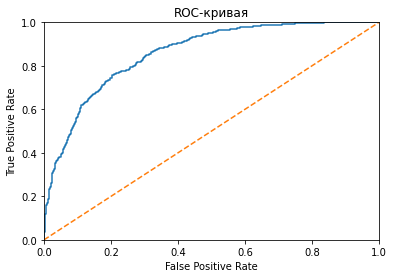

Показатель ROC_AUC: 0.858437393471433


In [87]:
# вычисляем вероятности положительных классов для тестовой выборки
probabilities_test = cb_up.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# перебираем fpr, tpr с разными порогами классификации
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
# строим график для fpr, tpr
plt.figure()
plt.plot(fpr, tpr)
# строим ROC-кривую случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
# задаем границы осей
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# задаем подписи осей и заголово 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
# выводим график
plt.show()
# выводим значение ROC_AUC
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Показатель ROC_AUC:', auc_roc)

- Модель достигла целевого показателя ROC_AUC. Она намного чаще, чем случайная дает истинноположительные ответы.

- Построим матрицу ошибок.

Матрица ошибок


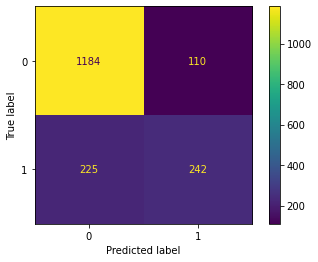

Precision: 0.6875
Recall: 0.5182012847965739


In [88]:
# формируем матрицу ошибок и строим по ней график
print('Матрица ошибок')
ConfusionMatrixDisplay.from_estimator(cb_up, features_test, target_test)
plt.show()
print('Precision:', precis_cb[0])
print('Recall:', rec_cb[0])

- На матрице ошибок мы видим 4 значения:
   - 1184 – истинноотрицательные ответы: модель правильно определила 1184 (91%) из 1294 (100%) остающихся клиентов (0:0). 
   - 110 – ложноположительные ответы: модель неправильно интерпретировала тех, кто остался (1:0).
   - 225 – ложноотрицательные ответы: модель неправильно выявила тех, кто уходит (0:1).
   - 242 – истинноположительные ответы: модель правильно детектировала 242 (52%) из 467 (100%) уходящих клиентов (1:1). Это метрика Recall. 
   -  Отношение истинноположительных ответов (242) ко всем определенным моделью положительным классам (242+110=352) – метрика Precision.

- Показатель Recall желательно было бы повысить, ведь эта метрика наиболее важна в нашей задаче. Действительно, если модель предскажет, что пользователь не уйдет, а он на самом деле уйдет, компания не предпримет ничего, чтобы его удержать и, в итоге, потеряет абонента, а с ним и доход.  

- С другой стороны, присвоив клиенту класс 1 (уход) 352 раза, модель ошиблась всего в 31% случаев (Precision - 69%), т.е. 110 клиентов, которые остались, модель определила как уходящих. Эта ошибка не несет в себе серьезных рисков: клиент из этого списка всего лишь попадет в рассылку промокодов, хотя, вероятнее всего, уходить не собирался.  

- Построим график важности признаков для нашей модели. 

### Анализ важности признаков

In [89]:
# создаем датафрейм с важностью признаков CatBoostClassifier
importances = pd.DataFrame(data={
          'Attribute': cb_up[:-1].get_feature_names_out(),
          'Importance': cb_up[-1].feature_importances_
      })
# удаляем префиксы для лучшей визуализации 
importances['Attribute'] = importances[
    'Attribute'].replace(['cat__','num__'],['',''],regex=True)

# проверяем
importances.sort_values(by='Importance', ascending=False)

,Attribute,Importance
3,Type,31.648169
1,TotalCharges,18.645591
0,MonthlyCharges,9.910995
11,OnlineSecurity,9.156829
14,TechSupport,7.145886
10,InternetService,5.892728
12,OnlineBackup,2.515289
5,PaymentMethod,2.461588
16,StreamingMovies,2.312845
2,DurationContract,2.202597


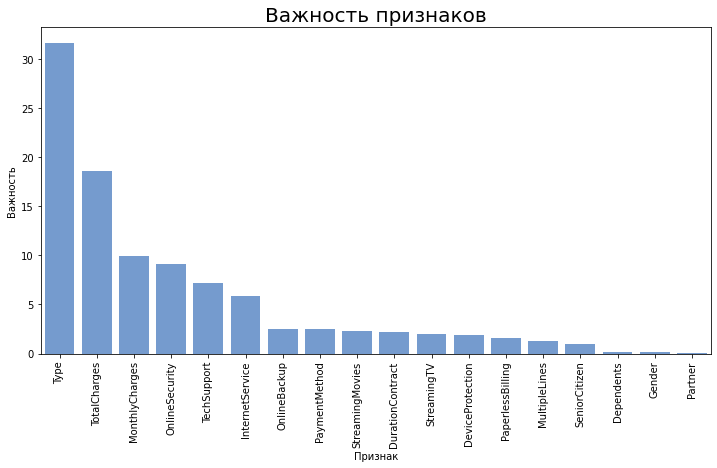

In [90]:
# строим график важности признаков CatBoostClassifier
importances = importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize = (12,6))
sns.barplot(x=importances['Attribute'], y=importances['Importance'], color="#69d")
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.show();

 - **Наиболее важный признак** для модели – тип оплаты (**'Type'**). По мнению нашей модели, именно тип оплаты сильнее всего влияет на отток пользователей. Действительно, при анализе признаков, мы выявили,  что с ростом интервала оплаты доля уходящих клиентов значительно снижается по сравнению с остающимися.


- Кроме признака типа оплаты в пятерку важнейших вошли *'TotalCharges', 'MonthlyCharges', 'OnlineSecurity' и 'TechSupport'*.


- Важность второго в рейтинге признака – *'TotalCharges'* – наиболее интуитивна. Легко предположить зависимость ухода от суммы общих расходов: чем выше сумма, тем дольше, по всей видимости, абонент пользуется услугами и тем реже он склонен разрывать контракт, и наоборот.


- Попадание в пятерку двух другим признаков (*'OnlineSecurity' и 'TechSupport'*), видимо, означает, что возможность обратиться в техподдержку и защититься от опасных сайтов значительно влияет на решение об уходе.  


- **К наименее важным** модель отнесла признаки социального статуса, пола, наличия детей и подключение к мультиканальной линии (*'Partner', 'Gender', 'Dependents','SeniorCitizen', 'MultipleLines'*). 

- Для признака 'TotalCharges' проведем дополнительное исследование: отобразим график зависимости с целевым признаком. 

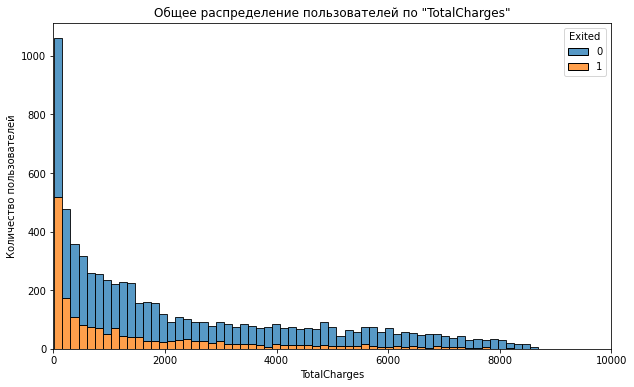

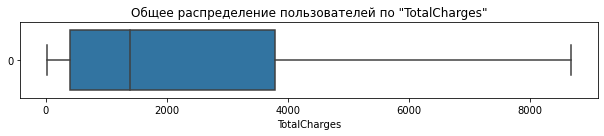

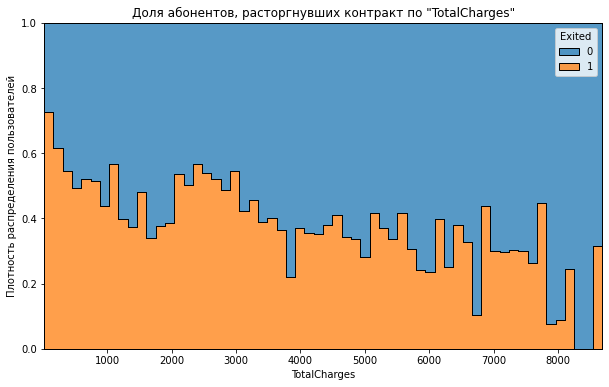

In [91]:
# строим гистограмму для 'TotalCharges'
hist_numeric_col('TotalCharges', 60, (0,10000), (8.5,2))

- Построим "скрипичный" график (распределения плотности вероятностей).

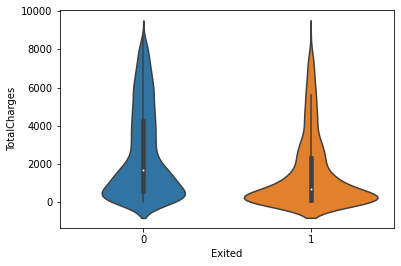

In [92]:
# делаем срез
df_query = df_main[['Exited','TotalCharges']]

# строим график 
sns.violinplot(data=df_query, x='Exited', y='TotalCharges');

- Да, доля ушедших клиентов меньше среди тех, у кого сумма трат выше. И наоборот: новички чаще разрывают контракт. 

### Вывод по четвертому шагу





- Протестировали модель, показавшую лучшую метрику на кросс-валидации – это **CatBoostClassifier** с *гиперпапаметрами: 'random_seed=150724', 'silent=True', 'loss_function="Logloss"', 'depth=3', 'iterations=1000', 'learning_rate=0.01'*.


- Получили значения метрик: 

  - ROC_AUC: 0.858437. 
  - Accuracy: 0.809767.
  - Precision: 0.6875.	
  - Recall: 0.51820.
  - F1: 0.590965.


- Сравнили работу нашей модели с константной. 


- Построили матрицу ошибок.


- Проанализировали важность признаков для модели и исследовали взаимосвязь одного из них (*'TotalCharges'*) с целевой переменной.  

## Общий вывод

Перед нами стояла цель – на предоставленных данных обучить модель прогнозировать отток клиентов со значением метрики ROC-AUC на тестовой выборке не менее 0.85.

В результате работы над проектом мы:

- Подключились к базе и загрузили таблицы sql.
  
- Провели исследовательский анализ данных и их предобработку.

- Подготовили данные и отобрали признаки для обучения.

- Создали и обучили модели для прогноза оттока клиентов. 

- Проверили и отобрали лучшую модель.

- Протестировали лучшую модель и продемонстрировали её работу.

- Написали промежуточные и общий выводы.


**Резюме:**

Лучшая модель CatBoostClassifier показала значение **ROC_AUC тестовой выборки – 0.858437**. Что выше заявленной цели. Т.е. модель с поставленной задачей справилась успешно.

Модель отлично подойдет для прогнозирования оттока клиентов, однако, можно улучшить показатели работы модели: собрать дополнительные данные о клиентах и сгенерировать дополнительные признаки из существующих данных. А также, расширить период времени, за который собраны данные. Эти шаги помогли бы повысить точность прогноза. 

Чтобы более точно детектировать клиентов, собирающихся покинуть компанию, стоит обратить внимание на тип оплаты, общие и ежемесячные расходы абонента. Вероятность ухода напрямую зависит от этих показателей.   